# Iterative Maximum Likelihood Estimation (iMLE)

Shahnawaz Ahmed, Chalmers University of Technology, Sweden  
Email: shahnawaz.ahmed95gmail.com  
GitHub: quantshah

### Introduction

Quantum State Tomography (QST) is the process of determining an unknown quantum state by making measurements on the system and using the measurement data to reconstruct the density matrix of the state. In this notebook, we will use QuTiP for the tomography of a cavity by counting photon number statistics (see [1, 2]). The data is from a "displace-and-measure" method on which we apply a statistical inference technique - iterative Maximum Likelihood Estimation (iMLE) [2] to reconstruct the full density matrix of an optical quantum state.

We consider a superposition of three coherent states (a three headed cat). We will use QuTiP to reproduce Fig 1(d) of Ref~[1] and reconstruct the Husimi Q function of a quantum state from measurements at the 5 marked points in the phase space.

![QuTiP logo](./images/tomography-result.png)

This notebook only shows an implementation of the basic iMLE which could be slow due to noise in the data (see below). We can consider other maximum likelihood methods for faster convergence such as the "diluted" MLE (Ref [3]) or the "superfast" MLE (Ref [4]). We can also consider neural-network based tomography using generative adversarial neural networks (Ref [5]).

In https://github.com/quantshah/qst-cgan/blob/master/examples/qst-cgan-vs-imle.ipynb we can find an example where iMLE fails to reconstruct a state even without noise while the neural-network-based approach works successfully. This failure of iMLE seems to be due to not selecting the correct measurements for iMLE explored in other notebooks in the repository https://github.com/quantshah/qst-cgan. Note that the Husimi Q function is considered as the data in the notebooks in Ref [5] while here we consider the generalized Q function.

## References

[1] Shen, Chao, et al. "Optimized tomography of continuous variable systems using excitation counting." Physical Review A 94.5 (2016): 052327.  
Link: https://arxiv.org/abs/1606.07554

[2] Řeháček, J., Z. Hradil, and M. Ježek. "Iterative algorithm for reconstruction of entangled states." Physical Review A 63.4 (2001): 040303.
Link: https://arxiv.org/abs/quant-ph/0009093

[3] Řeháček, Jaroslav, et al. "Diluted maximum-likelihood algorithm for quantum tomography." Physical Review A 75.4 (2007): 042108. Link: https://arxiv.org/abs/quant-ph/0611244

[4] Shang, Jiangwei, Zhengyun Zhang, and Hui Khoon Ng. "Superfast maximum-likelihood reconstruction for quantum tomography." Physical Review A 95.6 (2017): 062336. Link: https://arxiv.org/abs/1609.07881

[5] Ahmed, Shahnawaz, et al. "Quantum state tomography with conditional generative adversarial networks." arXiv preprint arXiv:2008.03240 (2020). Link: https://arxiv.org/abs/2008.03240

In [1]:
# imports 

import numpy as np

from qutip import Qobj, rand_dm, fidelity, displace, qdiags, qeye, expect
from qutip.states import coherent, coherent_dm, thermal_dm, fock_dm
from qutip.random_objects import rand_dm
from qutip.visualization import plot_wigner, hinton, plot_wigner_fock_distribution
from qutip.wigner import qfunc
import qutip

import matplotlib.pyplot as plt
from matplotlib import animation, colors


from IPython.display import clear_output

### Displacement operation

The measurements for determining optical quantum states usually rely on finding the probability of observing a certain number of photons in the cavity, i.e., measuring the photon number operator (occupation) $|n \rangle  \langle n|$ after displacing the state by applying the displacement operator $$ D(\beta) = e^{\beta a^{\dagger} - \beta^*a}.$$

Let us look at the effect of a displacement on a coherent state by applying a displacement $2 + 2i$ on the vacuum state. We can use the `displace` function in QuTiP to construct our displacement operator and apply it to the state vector for vacuum using the function `coherent`.

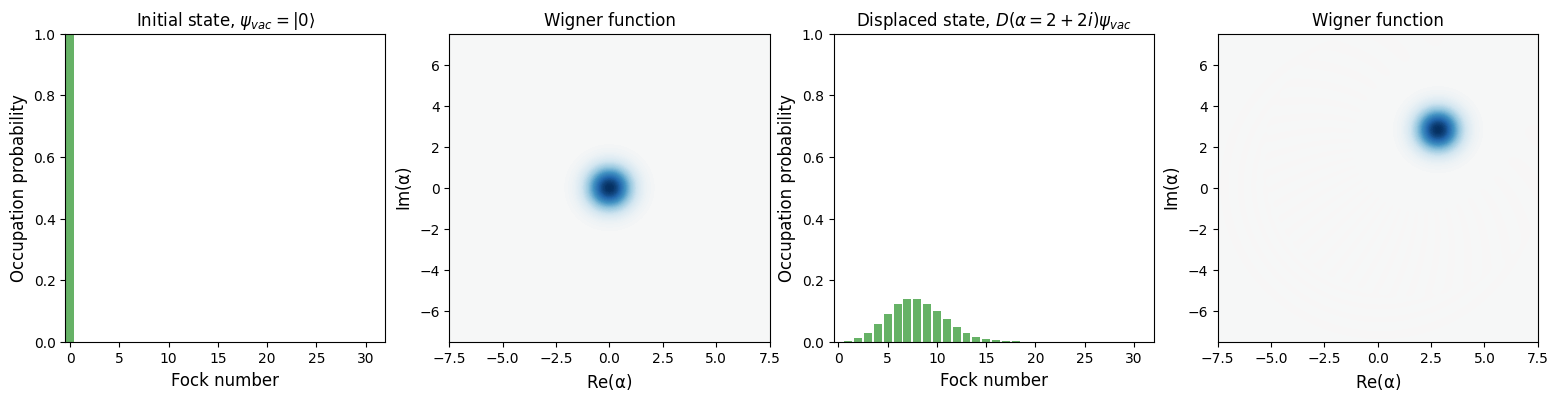

In [2]:
hilbert_size = 32
psi = coherent(hilbert_size, 0)
d = displace(hilbert_size, 2+2j)

fig, ax = plt.subplots(1, 4, figsize=(19, 4))

plot_wigner_fock_distribution(psi, fig=fig, axes=[ax[0], ax[1]])
plot_wigner_fock_distribution(d*psi, fig=fig, axes=[ax[2], ax[3]])

ax[0].set_title(r"Initial state, $\psi_{vac} = |0 \rangle$")
ax[2].set_title(r"Displaced state, $D(\alpha=2+2i )\psi_{vac}$")
plt.show()

### Optical quantum states in the fock basis

In the fock basis, we can describe optical quantum states as $|\psi \rangle = \sum_n^{N_{cut}}c_n |n \rangle$, where $N_{cut}$ is the photon number cutoff which truncates the Hilbert space and $|{c_n}|^2$ is the probability of observing $n$ photons. The coefficients $c_n$ can be complex-valued. The vaccum state $\psi_{vac} = |0 \rangle$ or a superposition of fock states containing two and three photons $\psi_{fock} = \frac{1}{\sqrt{2}}(|2 \rangle + |3 \rangle$ are some examples of simple optical quantum states. The coherent state is a displaced fock state $\psi_{\texttt{coherent}(\alpha)} = D(\alpha) |0 \rangle$ and a superposition of two such coherent states is defined as a CAT state,  
$$\psi_{\texttt{CAT}(\alpha)} = \frac{1}{N}[\psi_{\texttt{coherent}}(\alpha) + \psi_{\texttt{coherent}}(-\alpha)]$$ where $N$ is the normalization constant.

### A superposition of three coherent states

Let us construct a quantum state by taking the superposition of three coherent states. We first consider the state vector for the superposition of three coherent states, $\psi$ with $\alpha = (2, -2 - i, -2 + i)$. Note that the method `.unit()` in QuTiP gives us the normalized state. Then we find the density matrix of the state as $$ \rho = | \psi \rangle \langle \psi |$$

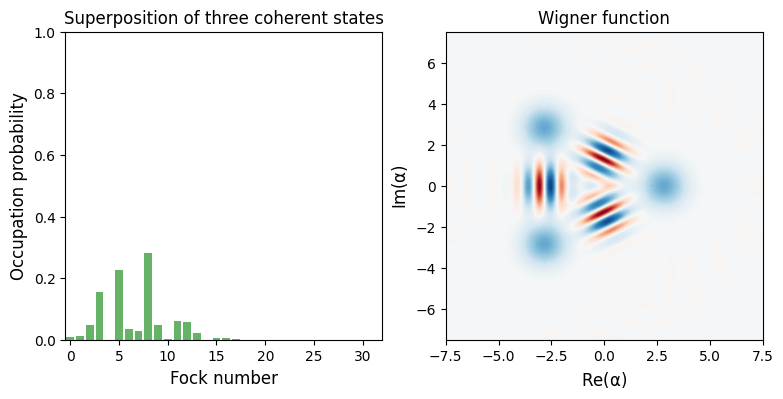

In [3]:
alpha_range = 2
alphas = np.array([alpha_range, -alpha_range - 1j*alpha_range,
                   -alpha_range + 1j*alpha_range])

psi = sum([coherent(hilbert_size, a) for a in alphas])
psi = psi.unit()
rho = psi*psi.dag()


fig, ax = plot_wigner_fock_distribution(rho, figsize=(9, 4))
ax[0].set_title("Superposition of three coherent states")
plt.show()

### Displace and measure - the generalized Q function

The expectation value of the photon number operators after applying a displacement $D(\beta_i)$ to the state density matrix $\rho = |\psi  \rangle \langle \psi|$ forms the so-called generalised $Q$ function:

$$Q_n^{\beta} = Tr[|n \rangle \langle n|D(-\beta) \rho D^\dagger(-\beta)$$

This type of "displace-and-measure" techniques can be seen as a generalization of some of the known observables in quantum optics, e.g., Husimi Q function $\frac{1}{\pi}Q_0^{\beta}$ which measures the vaccum state probability or the Wigner function which measures photon parity, $W(\beta) = (2/\pi)\sum_n (-1)^n Q_n^{\beta}$.

# Data
We apply displacements $\beta_i$ (left) marked as x on our state and measure expectation values of the photon number operators $|n \rangle \langle n|$. These are simply the diagonal elements of the density matrix. Note that alternatively we can just construct displaced photon number operators and measure their expectation values.

$$D(-\beta_i)|n \rangle \langle n| D^{\dagger}(-\beta_i)$$

We can see $Q_n^{\beta}$ for various values of $Q_n^{\beta_i}$ (colored bar plots) which forms the data, $d_i$. The density matrix itself is shown as a hinton plot on the right. The size of the boxes in the hinton plot represent the magnitude of the density matrix element and the color reflects the absolute value being positive or negative.

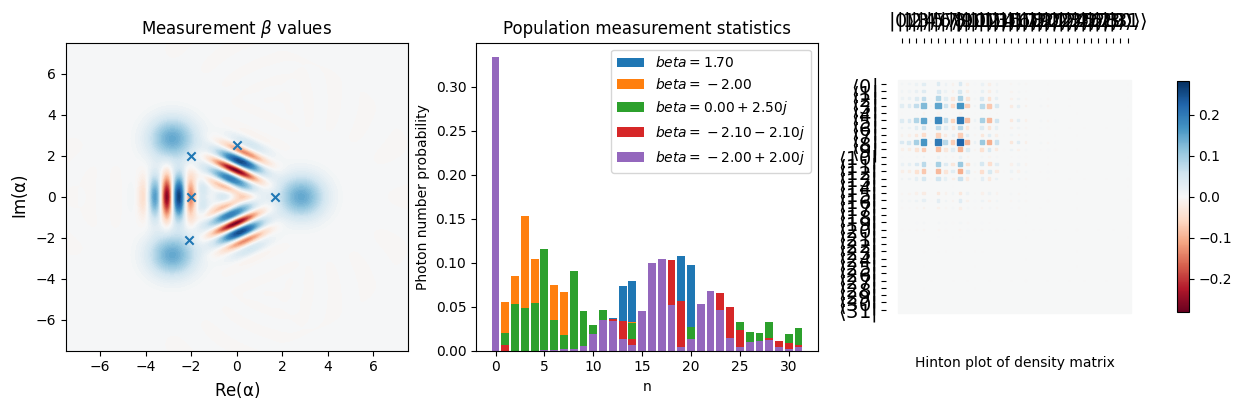

In [4]:
def measure_q(beta, rho):
    """
    Measures the generalized q function values for the state density matrix.
    
    Parameters
    ----------    
    beta: np.complex
        A complex displacement.

    rho:
        The density matrix as a QuTiP Qobj (`qutip.Qobj`)

    Returns
    -------
    population: ndarray
        A 1D array for the probabilities for populations.
    """
    hilbertsize = rho.shape[0]
    # Apply a displacement to the state and then measure the diagonals.

    D = displace(hilbertsize, -beta)
    rho_disp = D*rho*D.dag()
    
    # measure all the elements in the diagonal
    populations = np.real(np.diagonal(rho_disp.full()))
    return populations


betas = [1.7, -2, 2.5j, -2.1 - 2.1j, -2 + 2j]
generalized_Q = [measure_q(b, rho) for b in betas]


fig, ax = plt.subplots(1, 3, figsize=(15, 4))
indices = np.arange(hilbert_size)

plot_wigner(rho, fig, ax[0])
ax[0].scatter(np.real(betas), np.imag(betas), marker="x")
ax[0].set_title(r"Measurement $\beta$ values")

for i in range(len(betas)):
    ax[1].bar(indices, generalized_Q[i],
              label = r"$beta = {:.2f}$".format(betas[i]))

ax[1].set_title("Population measurement statistics")
ax[1].set_xlabel("n")
ax[1].set_ylabel("Photon number probability")

hinton(rho, ax=ax[2])
ax[2].set_xlabel("Hinton plot of density matrix")
ax[1].legend()

plt.show()

### Iterative Maximum Likelihood Estimation

The measurement statistics from different measurement settings, i.e., values of displacements could be made informationally complete such that they contain the full information required to reconstruct the state, (see Ref [1]). Once we have the data, the iterative Maximum Likelihood Estimation (iMLE) method [2] can be used to start from a random guess of the density matrix and determine the full density matrix by repeatedly applying an operator $R$ to a randomly initialized density matrix.

$R$ is a sum of projection operators into the measured basis - the displaced photon number operator in this case, $M_i = D(-\beta_i) |n \rangle \langle n|  D^{\dagger}(-\beta_i)$. Each such operator is weighted by the ratio of observed frequency of the measurement (empirical probability from experimental data, $d_i$) and the estimate of the same from the density matrix, $Tr[M_i \rho]$

$$R = \sum_i \frac{d_i}{Tr[M_i \rho]} M_i$$

Then, we iteratively apply $R$ as $$\rho_{k+1} = R \rho_{k} R$$ until convergence (with trace normalization after each iteration) to get the density matrix from the measured data.

### Constructing the R operator from current estimate of the density matrix

In [5]:
def construct_R(hilbert_size, betas, ops=None):
    """
    Calculates the set of operators R in a displace and measure method.

    Parameters
    ----------
    hilbert_size (int):
        The hilbert space size
    beta: list_like
        A list of the displacements that were applied to the state before
        measurement.

    op: list of :class:`qutip.Qobj`
        Measurement operators such as photon occupation |n><n| that should
        be used to construct the R operator for various displacements.
        default: |n><n| constructed using `qutip.fock_dm(hilbert_size, n)`
                 for all n.

    Returns
    -------
    R (list of `qutip.Qobj`) : 
        The list of iterative operators applied for state reconstruction.
    """
    if ops == None:
        ops = []
        for n in range(hilbert_size):
            ops.append(fock_dm(hilbert_size, n))

    R_ops = []

    for beta in betas:
        D = displace(hilbert_size, -beta)
        displaced_operators = []
        
        for operator in ops:
            displaced_D = D.dag()*operator*D
            displaced_operators.append(displaced_D)
        R_ops.append(displaced_operators)

    return R_ops


r_ops = construct_R(hilbert_size, betas)
expectation_values = [expect(r_ops[i], rho) for i in range(len(betas))]

# test if the expectation values calculated from the R operators match
# the previous calculations with the measure_q function
generalized_Q = [measure_q(b, rho) for b in betas]

np.allclose(expectation_values, generalized_Q)

True

### Reconstruction of the quantum state density matrix from (ideal) generalized $Q$ function measurements

In [6]:
r_ops = construct_R(hilbert_size, betas)
data = [expect(r_ops[i], rho) for i in range(len(betas))]


max_iter = 200

rho_reconstructed = qeye(hilbert_size)/hilbert_size # initial dm
rho_t = []
rho_t.append(rho_reconstructed)

fidelities = [fidelity(rho_reconstructed, rho)]

for iterations in range(max_iter):
    R = 0*qeye(hilbert_size)

    for i in range(len(betas)):
        # for all the n photons 
        for n in range(hilbert_size):
            r = r_ops[i][n]
            R += (data[i][n]/(expect(r, rho_reconstructed) + 1e-20))*r

    rho_reconstructed = R*rho_reconstructed*R

    # Trace renorm
    rho_reconstructed = rho_reconstructed/rho_reconstructed.tr()
    rho_t.append(rho_reconstructed)

    # Compute fidelity
    f = fidelity(rho_reconstructed, rho)
    fidelities.append(f)

    print(r"Iteration {}; Fidelity: {}".format(iterations, f))
    clear_output(wait=True)

Iteration 199; Fidelity: 0.9941291780526728


# Let us plot the Husimi $Q$ function - Fig 1(d) of Ref~[1]

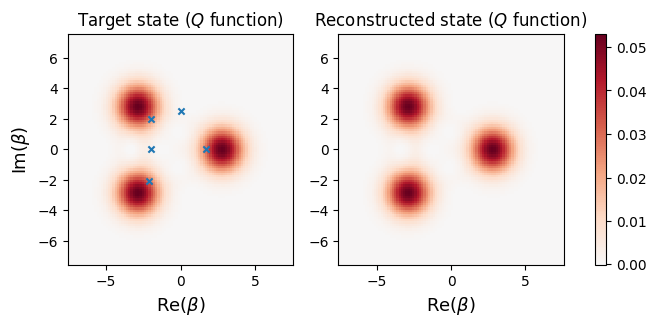

In [19]:
xvec = np.linspace(-7.5, 7.5, 100)
yvec = np.linspace(-7.5, 7.5, 100)

q_state = qfunc(rho, xvec, yvec)
q_reconstruction = qfunc(rho_reconstructed, xvec, yvec)

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
norm = colors.TwoSlopeNorm(vmin=-1e-9, vcenter=0, vmax=np.max(q_state))

ax[0].pcolor(xvec, yvec, q_state, norm=norm, cmap="RdBu_r", shading='auto')
im = ax[1].pcolor(xvec, yvec, q_reconstruction, norm=norm, cmap="RdBu_r", shading='auto')

ax[0].scatter(np.real(betas), np.imag(betas), marker="x", s=20)
ax[0].set_title(r"Target state ($Q$ function)")

ax[1].set_title("Reconstructed state ($Q$ function)")

ax[0].set_xlabel(r"Re($\beta$)", fontsize=13)
ax[0].set_ylabel(r"Im($\beta$)", fontsize=13)
ax[1].set_xlabel(r"Re($\beta$)", fontsize=13)
plt.colorbar(im, ax=[ax[0], ax[1]])

plt.show()

# We can also look at the density matrix of the states using Hinton plots

The Hinton plot for the complex-valued density matrix visualizes the density matrix elements. The size and shading of a blob in the plot is proportional to the magnitude of the density matrix and the color red (blue) is determined by whether the real part of the density matrix element is positive (negative). Let us look at the first 16 elements only of the reconstructed density matrix in comparison to the target.

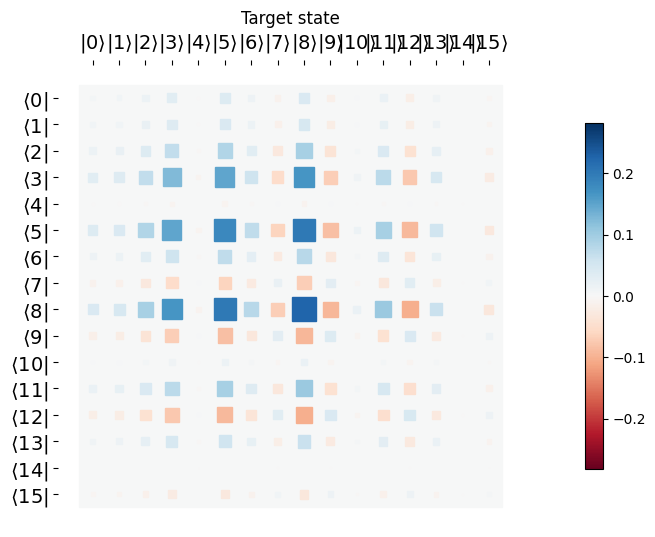

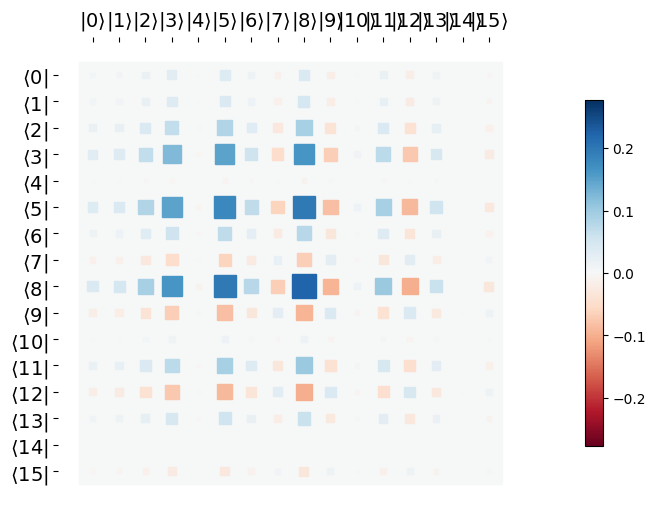

In [8]:
fig, ax = hinton(Qobj(rho[:16, :16]))
ax.set_title("Target state")
plt.show()
hinton(Qobj(rho_t[-1][:16, :16]))
ax.set_title("Reconstructed state")
plt.show()

# Discussion

In this tutorial, we have considered ideal measurements and have not introduced any noise in the data. In a real experiment, there will be noise both due to experimental errors as well as repetitions of measurements. A simple way to test the effects of noise is to include some Gaussian noise (with zero mean) in the data as follows:

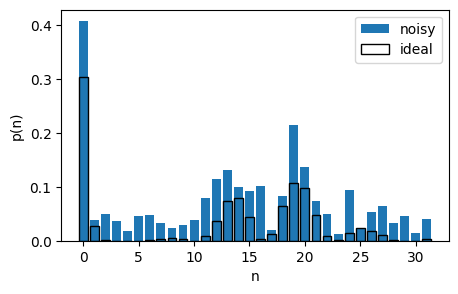

In [9]:
generalized_Q_noisy = generalized_Q + np.abs(np.random.normal(loc=0, scale=0.05, size = [len(betas), hilbert_size]))

plt.figure(figsize=(5,3))

for i in range(1):
    plt.bar(indices, generalized_Q_noisy[i],
              label = "noisy")
    plt.bar(indices, generalized_Q[i], fill=False,
              label = "ideal")
plt.xlabel("n")
plt.ylabel("p(n)")
plt.legend()
plt.show()

# Let us construct an iMLE function that we can reuse

In [27]:
def imle(data, r_ops, initial_rho=None, max_iter=200):
    """
    Implements the iterative maximum likelihood estimation algorithm.
    
    Args:
        data (array): An array representing measured data for a set of operators.
        r_ops (list of `qutip.Qobj`): The list of iterative operators applied
                                      for state reconstruction computed using the 
                                      set of measurement operators.
        initial_rho (`qutip.Qobj`): Initial density matrix estimate
                                    default: maximally mixed state (I/n).
        max_iter (int): The number of iterations to run .
    """
    if initial_rho is not None:
        rho_reconstructed = initial_rho
    else:
        rho_reconstructed = qeye(hilbert_size)/hilbert_size

    rho_t = []
    rho_t.append(rho_reconstructed)

    for iterations in range(max_iter):
        R = 0*qeye(hilbert_size)

        for i in range(len(r_ops)):
            # for all the n photons 
            for n in range(hilbert_size):
                r = r_ops[i][n]
                R += (data[i][n]/(expect(r, rho_reconstructed) + 1e-20))*r

        rho_reconstructed = R*rho_reconstructed*R

        # Trace renorm
        rho_reconstructed = rho_reconstructed/rho_reconstructed.tr()
        rho_t.append(rho_reconstructed)

        # Compute fidelity
        f = fidelity(rho_reconstructed, rho)
        print(r"Iteration {}; Fidelity: {}".format(iterations, f))
        clear_output(wait=True)
        
    return rho_t


rho_t_noisy = imle(generalized_Q_noisy, r_ops)

Iteration 199; Fidelity: 0.6147424388544597


# Visualizing the state reconstructed from noisy data

We find that adding a small amount of Gaussian noise to the data leads to a poorer reconstruction using 200 iterations. The general features of the state are present in the reconstruction, however the fidelity is very low.

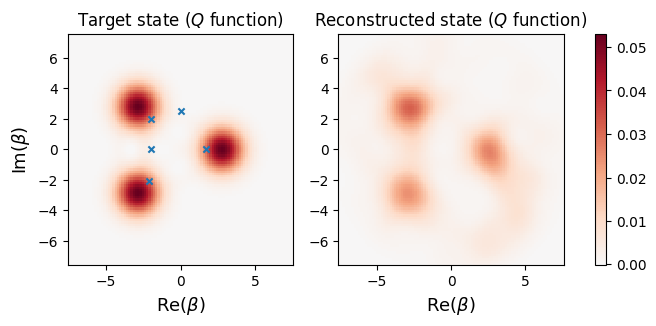

In [28]:
q_reconstruction_noisy = qfunc(rho_t_noisy[-1], xvec, yvec)

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
norm = colors.TwoSlopeNorm(vmin=-1e-9, vcenter=0, vmax=np.max(q_state))

ax[0].pcolor(xvec, yvec, q_state, norm=norm, cmap="RdBu_r", shading='auto')
im = ax[1].pcolor(xvec, yvec, q_reconstruction_noisy, norm=norm, cmap="RdBu_r", shading='auto')

ax[0].scatter(np.real(betas), np.imag(betas), marker="x", s=20)
ax[0].set_title(r"Target state ($Q$ function)")

ax[1].set_title("Reconstructed state ($Q$ function)")

ax[0].set_xlabel(r"Re($\beta$)", fontsize=13)
ax[0].set_ylabel(r"Im($\beta$)", fontsize=13)
ax[1].set_xlabel(r"Re($\beta$)", fontsize=13)
plt.colorbar(im, ax=[ax[0], ax[1]])

plt.show()

# More iterations

Let us now use 1000 iterations and run iMLE again. We find that the fidelity improves slightly but the increase in fidelity is very small compared to the number of iterations. We can consider other maximum likelihood methods for faster convergence such as the "diluted" MLE (Ref [3]) or the "superfast" MLE (Ref [4]). We can also consider neural-network based tomography using generative adversarial neural networks (Ref [5]). 

In [34]:
rho_t_noisy = imle(generalized_Q_noisy, r_ops, max_iter=1000)

Iteration 999; Fidelity: 0.6310074791923832


# QuTiP details

In [10]:
qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman and Simon Cross.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      4.6.1
Numpy Version:      1.19.2
Scipy Version:      1.5.2
Cython Version:     0.29.23
Matplotlib Version: 3.4.2
Python Version:     3.7.6
Number of CPUs:     6
BLAS Info:          Generic
OPENMP Installed:   False
INTEL MKL Ext:      False
Platform Info:      Darwin (x86_64)
Installation path:  /Users/shahnawaz/miniconda3/lib/python3.7/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qu